<a href="https://colab.research.google.com/github/h30e07/E4sosei/blob/main/AB_class_okisawa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AかつBの単語を1とする。
<br>
Aから見てBとどれだけ類似しているかを出力する。つまり、$w_a$と$w_b$を入れ替えると出力が変化する。
$$
similarityAtoB = \dfrac{1}{|A|}(\dfrac{|A-A\cap{B}|}{|A-A\cap{B}||B-A\cap{B}|}{\sum_{w_a\in{(A-A\cap{B})}}}\;{\sum_{w_b\in{(B-A\cap{B})}}}f(w_a, w_b)+\sum_{w_a\in{(A\cap{B})}}1)
\\A:シラバスAに現れる全単語の集合,
\\B:シラバスBに現れる全単語の集合,
\\f(w_a, w_b):単語w_aと単語w_bの関連度合いを-1～1の値で返す関数,
$$


# Google Drive マウント
（一番最初にこれを実行してください）

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# シラバスクラス

In [2]:
import re
class Syllabus:
    def __init__(self, path):
        self.path = path
        self.subject_name = re.sub('([0-9]+)', '', path.replace('/content/drive/MyDrive/sosei/meishi/meishi_', '').replace('.txt', '')).replace('()', '').replace('（）', '')
        self.subject_code = re.search('[0-9]{4}', path).group()
        self.grade = re.findall('_([0-9]{1})', path)[0]
        self.words = ""
        self.words_set = {}

    def set_words_set(self):
        with open(self.path) as s:
            self.words = s.read()
        self.words_set = set(self.words.split())
        return self.words_set

    def get_dict():
        output = {
            'path': self.path,
            'words': self.words,
            'words_set': self.words_set,
        }
        return output

# get_all_combinations関数

In [3]:
def get_all_combinations(sa_words, sb_words):
    all_combinations = []
    for sa_word in sa_words:
        for sb_word in sb_words:
            try:
                all_combinations.append(
                    {
                        'word1': sa_word,
                        'word2': sb_word,
                        'similarity': float(w2v_model.similarity(sa_word, sb_word))
                    }
                )
            except KeyError:
                pass
    sorted_all_combinations = sorted(all_combinations, key=lambda x: x['similarity'], reverse=True)
    return sorted_all_combinations

#関連性クラス

In [4]:
class Similarity:
    def __init__(self, words_combinations):
        self.words_combinations = words_combinations
        self.similarity = 0
        self.key_data = {}
        self.distribution = []

    def calc_similarity(self, sa_words_count, sb_words_count, sa_and_sb_count):  #重複している単語を1とする
        for  word_combination in self.words_combinations:
            self.similarity += word_combination['similarity']
        self.similarity = (self.similarity / sb_words_count + sa_and_sb_count) / (sa_words_count + sa_and_sb_count)
        return self.similarity
    
    def set_key_data(self, sa_subject_name, sb_subject_name):
        self.key_data = {
            'word_combination_sum': len(self.words_combinations),
            'min_similarity_value': self.words_combinations[-1]['similarity'],
            'max_similarity_value': self.words_combinations[0]['similarity'],
            'distribution': self.show_distribution(sa_subject_name, sb_subject_name)
        }
        return self.key_data


    def show_distribution(self, sa_subject_name, sb_subject_name):
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        fig = plt.figure()
        similarity_list = [d.get('similarity') for d in self.words_combinations]
        bins = np.arange(-1, 1, 0.1) # 等差数列
        sr = pd.Series(similarity_list)
        sr1 = pd.cut(sr, bins=bins)
        vc = sr1.value_counts(sort=False)
        y, ind, pacthes = plt.hist(sr,bins = bins.size-2, range =(-1,1))
        print('y', y)
        print('ind', ind)
        plt.xlabel("similarity")
        plt.ylabel("number of combinations")
        # plt.title(f"{sa_path.replace('/content/drive/MyDrive/sosei/meishi/meishi_', '')}, {sb_path.replace('/content/drive/MyDrive/sosei/meishi/meishi_', '')}", fontname="MS Gothic")
        plt.show()
        fig.savefig(f"/content/drive/MyDrive/sosei/result_data/沖澤AB_class_varの画像/{sa_subject_name}_{sb_subject_name}.png")
        return self.distribution
    
    def get_dict(self):
        output = {
            'similarity': self.similarity,
            #'key_data': self.key_data,
            #'words_combinations': self.words_combinations,
        }
        return output

# similarityを求める関数（計算方法を変えた場合はこの関数の内容を変えればよい）

In [ ]:
sa_and_sb_set = sa.words_set & sb.words_set # AかつBの集合
sa_remained_set = sa.words_set - sa_and_sb_set
sb_remained_set = sb.words_set - sa_and_sb_set
similarity = Similarity(get_all_combinations(sa_remained_set, sb_remained_set))
if len(sa_remained_set) != 0:   # AがBの部分集合出ないとき
    similarity.calc_similarity(len(sa_remained_set), len(sb_remained_set),len(sa_and_sb_set))
    similarity.set_key_data(sa.subject_name, sb.subject_name)
else:
    similarity.similarity = 1

# シラバスの全組み合わせを重複ありで返す関数
#(A,BとB,Aが出てくる)

In [5]:
def get_all_syllabus_combination():
    import glob
    import itertools
    output = []
    files = glob.glob(f"/content/drive/MyDrive/sosei/meishi/*")
    print(len(files))
    for i in files:
      for j in files:
        output.append([i,j])
    return output

In [6]:
def syllabus_similarity(sa_path, sb_path):
    """
    AかつBの単語を1として計算するメイン関数。
    入力の2つのファイルから求められたあらゆるデータは変数outputに格納される。

    Parameters
    ----------
    sa_path : string
        シラバスaの形態素解析済みのファイルのパス
    sb_path : string
        シラバスbの形態素解析済みのファイルのパス
    """
    
    sa = Syllabus(sa_path)
    sb = Syllabus(sb_path)
    sa.set_words_set()
    sb.set_words_set()
    
    # 本処理 
    sa_and_sb_set = sa.words_set & sb.words_set # AかつBの集合
    sa_remained_set = sa.words_set - sa_and_sb_set
    sb_remained_set = sb.words_set - sa_and_sb_set
    similarity = Similarity(get_all_combinations(sa_remained_set, sb_remained_set))
    if len(sa_remained_set) != 0:   # AがBの部分集合出ないとき
        similarity.calc_similarity(len(sa_remained_set), len(sb_remained_set),len(sa_and_sb_set))
        similarity.set_key_data(sa.subject_name, sb.subject_name)
    else:
        similarity.similarity = 1
    
    output = {
        'subject_combination': [sa.path, sb.path],
        'data': similarity.get_dict()
    }
    print('output', output)
    return output

# メインプログラム　AかつBの単語は1とする
（準備ができたらこれを実行してください）

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠA(2078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠA(2078).txt'], 'data': {'similarity': 1}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


y [  0.   0.   0.   0.   1.   4.  44. 125. 264. 377. 333. 258. 178. 144.
  89.  48.  15.  11.]
ind [-1.         -0.88888889 -0.77777778 -0.66666667 -0.55555556 -0.44444444
 -0.33333333 -0.22222222 -0.11111111  0.          0.11111111  0.22222222
  0.33333333  0.44444444  0.55555556  0.66666667  0.77777778  0.88888889
  1.        ]


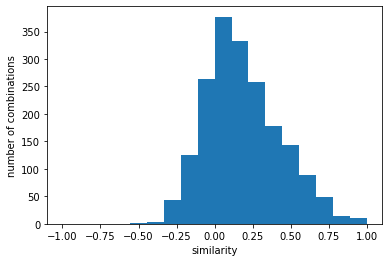

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠA(2078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠB(2079).txt'], 'data': {'similarity': 0.7470565570257529}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


y [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.300e+01 2.270e+02
 1.063e+03 2.201e+03 2.589e+03 2.251e+03 1.528e+03 9.230e+02 4.340e+02
 2.230e+02 7.700e+01 3.700e+01 6.000e+00]
ind [-1.         -0.88888889 -0.77777778 -0.66666667 -0.55555556 -0.44444444
 -0.33333333 -0.22222222 -0.11111111  0.          0.11111111  0.22222222
  0.33333333  0.44444444  0.55555556  0.66666667  0.77777778  0.88888889
  1.        ]


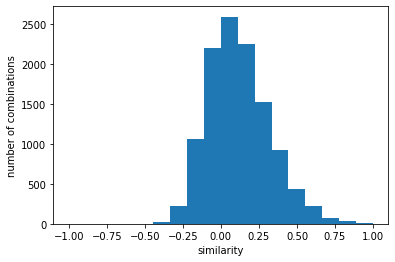

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠA(2078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_2微分積分学ⅠA(0018).txt'], 'data': {'similarity': 0.526669056568759}}


In [7]:
from gensim.models.word2vec import Word2Vec
from google.colab import files
import csv
import json

def test():
    syllabus_path = [
        '/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠA(2078).txt',
        '/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠB(2079).txt',
        '/content/drive/MyDrive/sosei/meishi/meishi_2微分積分学ⅠA(0018).txt'
    ]
    
    output.append(syllabus_similarity(syllabus_path[0], syllabus_path[0]))
    output.append(syllabus_similarity(syllabus_path[0], syllabus_path[1]))
    output.append(syllabus_similarity(syllabus_path[0], syllabus_path[2]))  
  
if __name__ == '__main__':
    output = []
    W2V_MODEL_PATH = '/content/drive/MyDrive/sosei/Pre-Trained Word2Vec Models/latest-ja-word2vec-gensim-model/word2vec.gensim.model'
    w2v_model = Word2Vec.load(W2V_MODEL_PATH)

    test()
    
    #for combination in get_all_syllabus_combination():
      #output.append(syllabus_similarity(combination[0], combination[1]))
    ### このプログラムを実行して得られた全てのデータをファイル出力 ###
    with open(f"/content/drive/MyDrive/sosei/result_data/沖澤AB_class_okisawa1のjson/data1.json", 'w') as f:
        json.dump(output, f, indent=2, ensure_ascii=False)